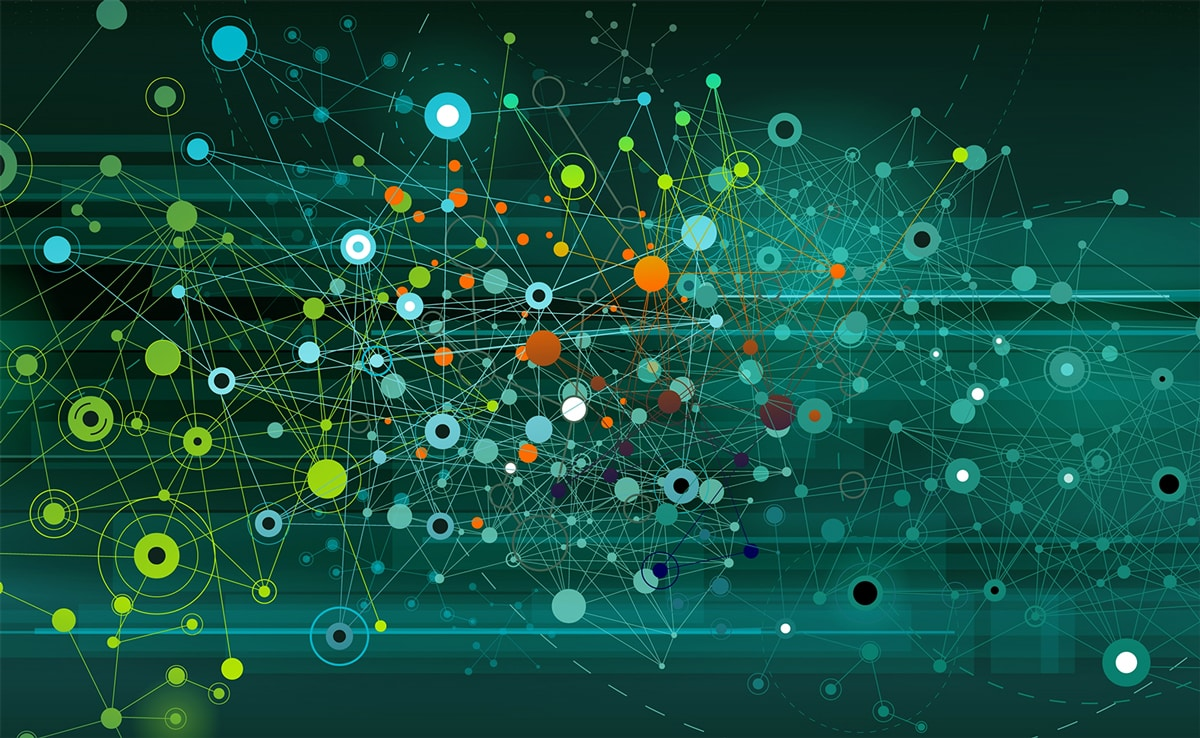
# Livrable 2

## Débruitage

### Groupe de projet :
- Rémi Papin
- Fabien Richard
- Zacharia Azzouzi
<br>
<br>

### Introduction

Dans un premier temps, ce livrable présente une méthode pour générer un dataset d'images bruités puis l'implémentation d'un autoencodeur capable de regénérer des images bruitées. Dans ce cas, les labels sont les images elles-mêmes.



## Import

L'ensemble des imports des bibliothèques pour mener à bien ce projet.

In [ ]:
%pip install opencv-python

In [1]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from PIL import Image
import configuration
import fidle.pwk as pwk
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import datetime
import pathlib
from tensorboard.plugins.hparams import api as hp
from skimage.util import random_noise
%matplotlib inline

data_dir = configuration.data_dir

## Datasets

Le script qui suit utilise toutes les images du dataset original pour générer un dataset équivalent d'image bruitée.

In [2]:
Comment this if you are sure thath= you want generate noisy dataset

for file in os.listdir(data_dir+"/clean"):
    # Load the image
    image = cv2.imread(os.path.join(data_dir+"/clean",file))
    if image is not None:
        # Add salt-and-pepper noise to the image
        noise = random_noise(image, mode='s&p', amount=0.03+(random.random()*0.5))

        # The above function returns a floating-point image in the range [0, 1]
        # so need to change it to 'uint8' with range [0,255]
        noise = np.array(255 * noise, dtype=np.uint8)
        cv2.imwrite(os.path.join(data_dir+"/noise",file),noise)
    #break # Uncomment to test the noisification on the first image only

SyntaxError: invalid syntax (<ipython-input-2-4f9f873052b0>, line 1)

In [33]:
image_h = 256
image_w = 256
batch_s = 8

validation_threshold=0.2

normalization_layer = tf.keras.layers.Rescaling(1./255)
flattend_layer = tf.keras.layers.Flatten()

valid_images = [".jpg",".gif",".png"]

# shuffle_in_unison can shuffle two array and keep index relations
def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

clean_set = []
noisy_set = []
for file in os.listdir(data_dir+"/clean")[:100]:
    ext = os.path.splitext(file)[1]
    if ext.lower() not in valid_images or not os.path.isfile(os.path.join(data_dir+"/noise",file)) :
        continue
    clean_img=cv2.imread(os.path.join(data_dir+"/clean",file))
    clean_img=cv2.resize(clean_img, (image_h, image_w))
    clean_img=clean_img.astype('float32') / 255.
    
    noisy_img=cv2.imread(os.path.join(data_dir+"/noise",file))
    noisy_img=cv2.resize(noisy_img, (image_h, image_w))
    noisy_img=noisy_img.astype('float32') / 255.
    clean_set.append(clean_img)
    noisy_set.append(noisy_img)
clean_set = np.array(clean_set, dtype=object)
noisy_set = np.array(noisy_set, dtype=object)
(clean_set, noisy_set)=shuffle_in_unison(clean_set, noisy_set)

split_index=int(noisy_set.shape[0]*(1-validation_threshold))

(clean_train_set, clean_test_set)=np.split(clean_set, [split_index])
(noisy_train_set, noisy_test_set)=np.split(noisy_set, [split_index])

print("Found {:d} clean files, {:d} train / {:d} test".format(clean_set.shape[0], clean_train_set.shape[0], clean_test_set.shape[0]))
print("Found {:d} noisy files, {:d} train / {:d} test".format(noisy_set.shape[0], noisy_train_set.shape[0], noisy_test_set.shape[0]))

Found 100 clean files, 80 train / 20 test
Found 100 noisy files, 80 train / 20 test


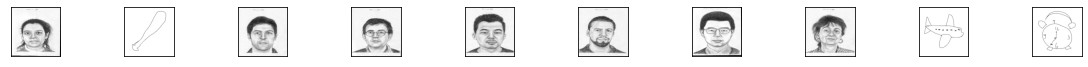

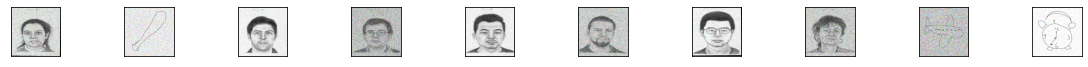

In [34]:
def display_image(X, n):
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(X[i].astype('float32'))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

display_image(clean_train_set, n=10)
display_image(noisy_train_set, n=10)

## Construction du modèle 1 couche de convolution
Pour réaliser ce modèle nous avons créé une architecture reposant sur plusieurs couches :

- Une layers Rescaling :
- Une layers Conv2D :
- Une layers MaxPooling2D :
- Une layers Dropout :
- Une layers Flatten :
- Une layers Dense :
- Une layers Dense :


In [36]:
def build_autoencoder(height, width, depth, filters=(32, 64)):
    # initialize the input shape to be "channels last" along with
    # the channels dimension itself
    # channels dimension itself
    inputShape = (height, width, depth)
    chanDim = -1
    # define the input to the encoder
    inputs = layers.Input(shape=inputShape)
    x = inputs
    # loop over the number of filters
    for f in filters:
        # apply a CONV => MAX_POOLING
        x = layers.Conv2D(f, (3, 3), activation='relu', padding="same")(x)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)
        
    # loop over our number of filters again, but this time in
    # reverse order
    for f in filters[::-1]:
        # apply a CONV => UP_SAMPLING
        x = layers.Conv2D(f, (3, 3), activation='relu', padding='same')(x)
        x = layers.UpSampling2D((2, 2))(x)
    # apply a single CONV_TRANSPOSE layer used to recover the
    # original depth of the image
    x = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    # our autoencoder is the encoder + decoder
    autoencoder = keras.models.Model(inputs, x,
        name="autoencoder")
    # return a 2-tuple of the input and autoencoder
    return (inputs, autoencoder)


(encoder_inputs, autoencoder) = build_autoencoder(image_h, image_w, 3, filters=(16, 32, 64))

# Résumé du modèle
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_57 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_59 (Conv2D)          (None, 64, 64, 64)        

### Checkpoint

Pour ne pas perdre du temps à ré entrainer les models à chaque fois nous réalisons des checkpoints nous permettant de conserver les valeurs de notre modèle le plus performant. 

In [37]:
# Prepare for model checkpoints
checkpoint_path = "training/cp_autoencoder_{epoch:02d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 mode='min')

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)
hparams_callback = hp.KerasCallback(log_dir, {
    'num_relu_units': 16,
    'dropout': 0.2
})

### Entrainement du modèle

In [38]:
# Compiler le modèle
autoencoder.compile(optimizer="adam",loss= 'binary_crossentropy')

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.5180
Epoch 00001: val_loss improved from inf to 0.42904, saving model to training/cp_autoencoder_01.ckpt
10/10 [==============================] - 2s 73ms/step - loss: 0.5180 - val_loss: 0.4290
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.4113
Epoch 00002: val_loss improved from 0.42904 to 0.42402, saving model to training/cp_autoencoder_02.ckpt
10/10 [==============================] - 0s 44ms/step - loss: 0.4113 - val_loss: 0.4240
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.3928
Epoch 00003: val_loss improved from 0.42402 to 0.40307, saving model to training/cp_autoencoder_03.ckpt
10/10 [==============================] - 0s 44ms/step - loss: 0.3928 - val_loss: 0.4031
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.3792
Epoch 00004: val_loss improved from 0.40307 to 0.39357, saving model to training/cp_autoencoder_04.ckpt
10/10 [=============

10/10 [==============================] - 0s 39ms/step - loss: 0.2887 - val_loss: 0.3118
Epoch 35/100
10/10 [==============================] - ETA: 0s - loss: 0.2869
Epoch 00035: val_loss did not improve from 0.30814
10/10 [==============================] - 0s 38ms/step - loss: 0.2869 - val_loss: 0.3083
Epoch 36/100
10/10 [==============================] - ETA: 0s - loss: 0.2851
Epoch 00036: val_loss improved from 0.30814 to 0.30675, saving model to training/cp_autoencoder_36.ckpt
10/10 [==============================] - 0s 42ms/step - loss: 0.2851 - val_loss: 0.3067
Epoch 37/100
10/10 [==============================] - ETA: 0s - loss: 0.2846
Epoch 00037: val_loss did not improve from 0.30675
10/10 [==============================] - 0s 38ms/step - loss: 0.2846 - val_loss: 0.3078
Epoch 38/100
10/10 [==============================] - ETA: 0s - loss: 0.2845
Epoch 00038: val_loss did not improve from 0.30675
10/10 [==============================] - 0s 38ms/step - loss: 0.2845 - val_loss: 0.

10/10 [==============================] - ETA: 0s - loss: 0.2809
Epoch 00069: val_loss did not improve from 0.30177
10/10 [==============================] - 0s 38ms/step - loss: 0.2809 - val_loss: 0.3027
Epoch 70/100
10/10 [==============================] - ETA: 0s - loss: 0.2795
Epoch 00070: val_loss improved from 0.30177 to 0.30151, saving model to training/cp_autoencoder_70.ckpt
10/10 [==============================] - 0s 42ms/step - loss: 0.2795 - val_loss: 0.3015
Epoch 71/100
10/10 [==============================] - ETA: 0s - loss: 0.2794
Epoch 00071: val_loss did not improve from 0.30151
10/10 [==============================] - 0s 37ms/step - loss: 0.2794 - val_loss: 0.3020
Epoch 72/100
10/10 [==============================] - ETA: 0s - loss: 0.2800
Epoch 00072: val_loss did not improve from 0.30151
10/10 [==============================] - 0s 36ms/step - loss: 0.2800 - val_loss: 0.3038
Epoch 73/100
10/10 [==============================] - ETA: 0s - loss: 0.2796
Epoch 00073: val_lo

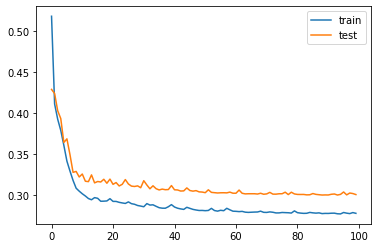

In [39]:
epochs=100

# Exécution du modèle
history = autoencoder.fit(tf.convert_to_tensor(noisy_train_set, dtype=tf.float32), tf.convert_to_tensor(clean_train_set, dtype=tf.float32),
                          epochs=epochs, batch_size=batch_s,
                          shuffle=True,
                          validation_data=(tf.convert_to_tensor(noisy_test_set, dtype=tf.float32), tf.convert_to_tensor(clean_test_set, dtype=tf.float32)),
                          callbacks=[cp_callback,tensorboard_callback])
 

# Save the model
save_path = "checkpoints/"+datetime.datetime.now().strftime("%d-%m-%Y_%H-%M-%S")+".ckpt"
autoencoder.save_weights(save_path)

# Visualisation des pertes d'apprentissage (Train) et de validation (Test)
plt.plot( history.history['loss'],
         label='train')
plt.plot( history.history['val_loss'],
         label='test')
plt.legend()

In [40]:
decoded_imgs = autoencoder.predict(tf.convert_to_tensor(noisy_test_set, dtype=tf.float32))

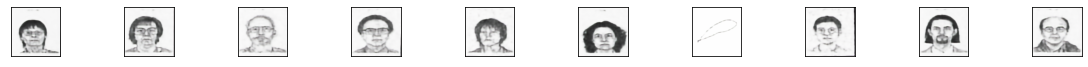

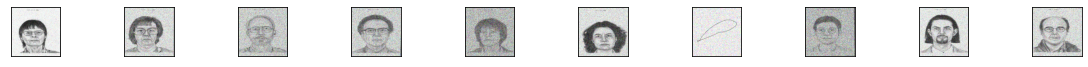

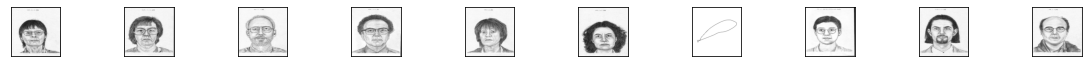

In [41]:
display_image(decoded_imgs, 10)
display_image(noisy_test_set, 10)
display_image(clean_test_set, 10)

In [5]:
!tensorboard dev upload --logdir ./logs \
  --name "Livrable 2 : Projet Datascience - Leyenda." \
  --description "Modèle autoencodeur de débruitage." \
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/CzyhOskOR6O2CJ2PnDR6dQ/

[2021-12-14T13:52:47] Started scanning logdir.
[2021-12-14T13:52:47] Done scanning logdir.
TensorBoard was run in `one_shot` mode, but did not find any uploadable data in the specified logdir: ./logs
An empty experiment was created. To delete the empty experiment you can execute the following

    tensorboard dev delete --experiment_id=CzyhOskOR6O2CJ2PnDR6dQ


Done.
